In [1]:
from gurobipy import Model, GRB
import numpy as np
import torch
import matplotlib.pyplot as plt

# Toy problem in gurobi

In [55]:
def solve_gromov_wasserstein(mu, nu, dx, dy):
    """
    Solves the Gromov-Wasserstein quadratic program using Gurobi.

    Parameters:
        mu (numpy.ndarray): Source distribution, shape (n,).
        nu (numpy.ndarray): Target distribution, shape (m,).
        G (numpy.ndarray): Quadratic cost matrix, shape (nm, nm).

    Returns:
        numpy.ndarray: Optimal transport matrix T, shape (n, m).
    """
    # Dimensions
    n = len(mu)
    m = len(nu)

    # Create a Gurobi model
    model = Model("Gromov-Wasserstein")

    # Add variables for T (n x m), flattened as a single vector
    T = model.addVars(n, m, lb=0, vtype=GRB.CONTINUOUS, name="T")

    # Flatten T for indexing consistency
    # T_vec = T.flatten()

    # Add marginal constraints
    # Row marginal: sum_j T[i, j] = mu[i]
    for i in range(n):
        model.addConstr(sum(T[i, j] for j in range(m)) == mu[i])

    # Column marginal: sum_i T[i, j] = nu[j]
    for j in range(m):
        model.addConstr(sum(T[i, j] for i in range(n)) == nu[j])

    obj = 0
    for i in range(n):
        for j in range(m):
            for k in range(n):
                for el in range(m):
                    # obj += -2*(Cx[i,j] * Cy[k,el]) * T[i, k] * T[j,el]
                    obj += n*n*0.5*(dx[i, j]**2 - dy[k, el]**2) ** 2 * T[i, k] * T[j, el]
    # obj = 0.5 * sum(
    #     G[i, j] * T_vec[i] * T_vec[j] for i in range(n * m) for j in range(n * m)
    # )
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Extract solution
    if model.Status == GRB.OPTIMAL:
        T_opt = np.array([[T[i, j].X for j in range(m)] for i in range(n)])
        # T_opt = T
        return T_opt, model
    else:
        print("Optimization failed!")
        return None, None

np.random.seed(0)
# Example usage
n = m = 14
mu = np.ones(n) #np.random.rand(n)
mu /= mu.sum()  # Normalize to sum to 1
nu = np.ones(m) #np.random.rand(m)
nu /= nu.sum()  # Normalize to sum to 1
points_x = np.random.randn(n, 2) # 2*np.stack([np.arange(n), np.zeros(n)]).T #3*(np.arange(2*n)**2).reshape((n,2)) #
scale = 0.1
points_y = np.random.normal(points_x, scale)
# points_y = points_x.copy()  #np.stack([np.arange(n)+1, np.zeros(n)]).T
# points_y[0,0] += 1

def cdist(x, y):
    return np.sum((x[:, None] - y[None, :]) ** 2, axis=-1)


dx = np.sqrt(cdist(points_x, points_x)) # papers dx is dx**2
dy = np.sqrt(cdist(points_y, points_y))

Cx = dx**2
Cy = dy**2


In [56]:
T_optimal = np.eye(n)

mx = np.linalg.norm(points_x, axis=1)**2
my = np.linalg.norm(points_y, axis=1)**2
vec_1x = np.ones(n) 
vec_1y = np.ones(m)

In [57]:
assert np.allclose(Cx,  np.outer(vec_1x,mx) - 2*points_x @ points_x.T + np.outer(mx,vec_1x))
assert np.allclose(Cy, np.outer(vec_1y,my) - 2*points_y @ points_y.T + np.outer(my,vec_1y))

In [58]:
L = 2*n*np.outer(mx,my) 
L -= 4*np.outer(mx,vec_1x) @ (points_y @ points_y.T) 
L -= 4*(points_x @ points_x.T) @ np.outer(vec_1y,my) 
cross = ((2*points_x.T @ T_optimal @ points_y)**2).sum() + (L*T_optimal).sum() + 2*vec_1y.dot(my)*vec_1x.dot(mx)

assert np.allclose(((Cx@T_optimal)*(T_optimal@Cy)).sum(),cross)

cross

9493.57931988761

In [59]:
assert np.allclose(((Cx@T_optimal)*(T_optimal@Cy)).sum(), np.trace(((Cx@T_optimal).T@(T_optimal@Cy))))

In [60]:
assert np.allclose(2*vec_1y.dot(my)*vec_1x.dot(mx), 2*vec_1y.dot(np.outer(my,vec_1x)).dot(mx))

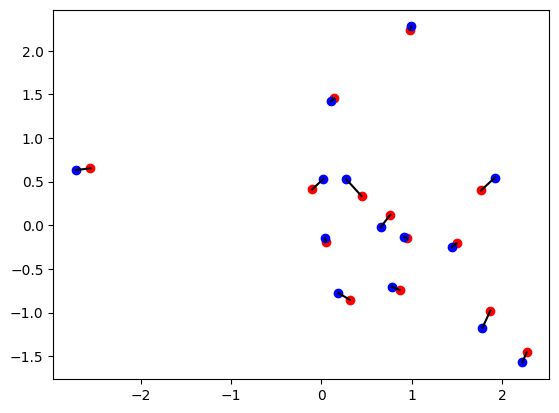

In [61]:
# show x and y points
plt.scatter(points_x[:, 0], points_x[:, 1], c="r", label="x")
plt.scatter(points_y[:, 0], points_y[:, 1], c="b", label="y")

# connect pairs
for i in range(n):
        plt.plot(
        [points_x[i, 0], points_y[i, 0]],
        [points_x[i, 1], points_y[i, 1]],
        "k-",
    )

In [62]:
# k = 7
# points = np.zeros((k,2))
# points[:,0] = np.arange(k)

# cdist(points,points)

In [64]:
((dx - dy)**2).sum() / 2 # assuming diagonal transport matrix (upper bound)

2.011326748528923

In [65]:
((dx**2 - dy**2)**2).sum() / 2 # assuming diagonal transport matrix (upper bound)

37.974920252699306

In [66]:
T_optimal, model = solve_gromov_wasserstein(mu, nu, dx, dy)
print("Optimal Transport Matrix:\n", T_optimal)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Rocky Linux 9.5 (Blue Onyx)")

CPU model: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 28 rows, 196 columns and 392 nonzeros
Model fingerprint: 0x006566c4
Model has 19110 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [9e-05, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 7e-02]
Presolve removed 1 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve time: 0.04s
Presolved: 38249 rows, 19308 columns, 95943 nonzeros
Presolved model has 19110 bilinear constraint(s)
Variable types: 19308 continuous, 0 integer (0 binary)
Found heuristic solution: objective 37.9749203

Root relaxation: objective 0.000000e+00, 934 iterations, 0.20 seconds (0.15 work units)

  

In [67]:
model.objVal

37.97492025269929

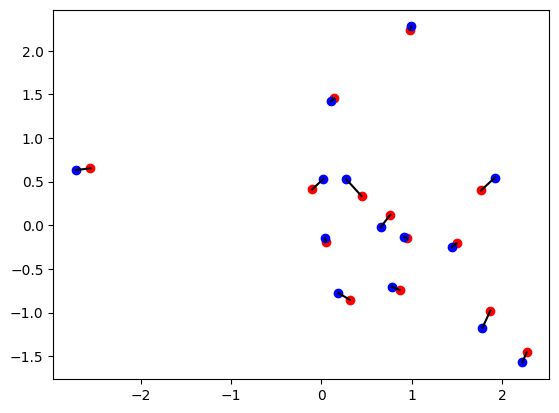

In [68]:
# show x and y points
plt.scatter(points_x[:, 0], points_x[:, 1], c="r", label="x")
plt.scatter(points_y[:, 0], points_y[:, 1], c="b", label="y")


# connect pairs
for i in range(n):
    for j in range(m):
        if T_optimal[i, j] > 1e-3:
            plt.plot(
                [points_x[i, 0], points_y[j, 0]],
                [points_x[i, 1], points_y[j, 1]],
                "k-",
                alpha=T_optimal[i, j]/T_optimal.max(),
            )

In [69]:
T_optimal*n

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [70]:
T = T_optimal*n
(-((dx**2 @ T) * (T @ dy**2)).sum() + 0.5*(np.linalg.norm(dx**2,'fro')**2 + np.linalg.norm(dy**2,'fro')**2)) 

37.97492025270003

In [71]:
T = T_optimal*n 

mx = np.linalg.norm(points_x, axis=1)**2
my = np.linalg.norm(points_y, axis=1)**2
vec_1x = np.ones(n) 
vec_1y = np.ones(m)

L = 2*n*np.outer(mx,my) 
L -= 4*np.outer(mx,vec_1x) @ (points_y @ points_y.T) 
L -= 4*(points_x @ points_x.T) @ np.outer(vec_1y,my) 
diag = ((Cx**2).sum() + (Cy**2).sum())/2 
c0 = diag - 2*vec_1y.dot(my)*vec_1x.dot(mx)
obj = - np.linalg.norm((2*points_x.T @ T @ points_y),'fro')**2 - (L*T).sum() + c0
obj

37.97492025270094

In [72]:
X = points_x.T
Y = points_y.T
mx = mx.reshape(-1, 1)
my = my.reshape(-1, 1)
vec_1y = np.ones((m, 1))
vec_1x = np.ones((n, 1))
L_ = (
    (n + m) * mx @ my.T
    - 4 * mx @ vec_1y.T @ Y.T @ Y
    - 4 * X.T @ X @ vec_1x @ my.T
)

c0_ = (np.sum(Cx**2) + np.sum(Cy**2))/2 - 2 * np.sum(mx) * np.sum(my)

(-np.sum((2 * X @ T @ Y.T) ** 2) - np.sum(L * T) + c0_).item()

37.97492025270003

 # exploit structure of Cx, Cy

In [121]:
def solve_gromov_wasserstein(mu, nu, Cx, Cy):
    """
    Solves the Gromov-Wasserstein quadratic program using Gurobi.

    Parameters:
        mu (numpy.ndarray): Source distribution, shape (n,).
        nu (numpy.ndarray): Target distribution, shape (m,).
        G (numpy.ndarray): Quadratic cost matrix, shape (nm, nm).

    Returns:
        numpy.ndarray: Optimal transport matrix T, shape (n, m).
    """
    # Dimensions
    n = len(mu)
    m = len(nu)

    # Create a Gurobi model
    model = Model("Gromov-Wasserstein")

    # Add variables for T (n x m), flattened as a single vector
    T = model.addVars(n, m, lb=0, vtype=GRB.CONTINUOUS, name="T")

    # Flatten T for indexing consistency
    # T_vec = T.flatten()

    # Add marginal constraints
    # Row marginal: sum_j T[i, j] = mu[i]
    for i in range(n):
        model.addConstr(sum(T[i, j] for j in range(m)) == mu[i])

    # Column marginal: sum_i T[i, j] = nu[j]
    for j in range(m):
        model.addConstr(sum(T[i, j] for i in range(n)) == nu[j])

    obj = 0
    for i in range(n):
        for j in range(m):
            for k in range(n):
                for el in range(m):
                    # obj += -2*(Cx[i,j] * Cy[k,el]) * T[i, k] * T[j,el]
                    obj += (Cx[i, j] - Cy[k, el]) ** 2 * T[i, k] * T[j, el]
    # obj = 0.5 * sum(
    #     G[i, j] * T_vec[i] * T_vec[j] for i in range(n * m) for j in range(n * m)
    # )
    model.setObjective(obj, GRB.MINIMIZE)

    # Optimize the model
    model.optimize()

    # Extract solution
    if model.Status == GRB.OPTIMAL:
        T_opt = np.array([[T[i, j].X for j in range(m)] for i in range(n)])
        # T_opt = T
        return T_opt, model
    else:
        print("Optimization failed!")
        return None, None


# Example usage
n = m = 3
mu = np.ones(n) #np.random.rand(n)
mu /= mu.sum()  # Normalize to sum to 1
nu = np.ones(m) #np.random.rand(m)
nu /= nu.sum()  # Normalize to sum to 1
points_x = np.random.randn(n, 2)
scale = 0.1
points_y = np.random.normal(points_x, scale)


def cdist(x, y):
    return np.sum((x[:, None] - y[None, :]) ** 2, axis=-1)


Cx = cdist(points_x, points_x)
Cy = cdist(points_y, points_y)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 3)

In [120]:
model.objVal*n**4

2022.5260258121903

In [118]:
np.linalg.norm(np.ones((3,3)), 'fro')**2

9.0

Verify objective

# Problem formulations: GW as QP

In [15]:
class Args:
    n_i = 1
    n_j = 4
    n_downsample_pix = 20
    top_k = 3
    exponent = 1
    scheduler = "none"
    element_wise = False
    cost_scale_factor = 1.0


args = Args()
torch_dtype = torch.float32

n_downsample_pix = args.n_downsample_pix
top_k = args.top_k
exponent = args.exponent
scheduler = args.scheduler
element_wise = args.element_wise
cost_scale_factor = args.cost_scale_factor
normalize = True

In [17]:
fname = "/mnt/home/smbp/ceph/smbpchallenge/round2/set2/processed_submissions/submission_23.pt"
submission = torch.load(fname, weights_only=False)
volumes = submission["volumes"].to(torch_dtype)

In [18]:
volumes_i = volumes[: args.n_i]
volumes_j = volumes[: args.n_j]

In [19]:
from gw_weighted_voxels import prepare_volume_and_distance

marginals_i = np.empty((len(volumes_i), top_k))
marginals_j = np.empty((len(volumes_j), top_k))
pairwise_distances_i = np.empty((len(volumes_i), top_k, top_k))
pairwise_distances_j = np.empty((len(volumes_j), top_k, top_k))

for i in range(len(volumes_i)):
    volume_i, pairwise_distance_i = prepare_volume_and_distance(
        volumes_i[i], top_k, n_downsample_pix, exponent, cost_scale_factor, normalize
    )
    marginals_i[i] = volume_i
    pairwise_distances_i[i] = pairwise_distance_i
for j in range(len(volumes_j)):
    volume_j, pairwise_distance_j = prepare_volume_and_distance(
        volumes_j[j], top_k, n_downsample_pix, exponent, cost_scale_factor, normalize
    )
    marginals_j[j] = volume_j
    pairwise_distances_j[j] = pairwise_distance_j

In [ ]:
# def generate_G(Cx, Cy):
#     """
#     Generate the quadratic cost matrix G for the Gromov-Wasserstein problem.

#     Parameters:
#         Cx (numpy.ndarray): Distance matrix for the source space, shape (n, n).
#         Cy (numpy.ndarray): Distance matrix for the target space, shape (m, m).

#     Returns:
#         numpy.ndarray: Quadratic cost matrix G, shape (nm, nm).
#     """
#     n, m = Cx.shape[0], Cy.shape[0]

#     # Initialize the G matrix with zeros
#     G = np.zeros((n * m, n * m))

#     # Fill in G using the formula
#     for i in range(n):
#         for j in range(m):
#             for k in range(n):
#                 for el in range(m):
#                     idx1 = i * m + j  # Flattened index for (i, j)
#                     idx2 = k * m + el  # Flattened index for (k, l)
#                     G[idx1, idx2] = -2*Cx[i, j]*Cy[k,el]
#                     # G[idx1, idx2] = (Cx[i, j] - Cy[k,el])**2

#     return G


gw_distance = np.zeros((len(volumes_i), len(volumes_j)))
transport_plans = np.zeros((len(volumes_i), len(volumes_j), top_k, top_k))
for idx_i in range(len(volumes_i)):
    for idx_j in range(len(volumes_j)):
        print(f"between {idx_i} and {idx_j}...")
        if idx_i <= idx_j:
            print(f"Computing GW distance between {idx_i} and {idx_j}...")

            n = m = top_k
            Cx = pairwise_distances_i[idx_i]
            Cy = pairwise_distances_j[idx_j]

            # Ensure the distance matrices are symmetric and non-negative
            Cx = 0.5 * (Cx + Cx.T)
            Cy = 0.5 * (Cy + Cy.T)
            Cx[Cx < 0] = 0
            Cy[Cy < 0] = 0

            # G = generate_G(Cx, Cy)
            mu = marginals_i[idx_i]
            nu = marginals_j[idx_j]
            T_optimal, model = solve_gromov_wasserstein(mu, nu, Cx, Cy)
            # gw_distance[idx_i, idx_j] = gw_distance[idx_j, idx_i] = model.ObjVal
            gw_distance[idx_i, idx_j] = model.ObjVal
            # gw_distance[idx_i, idx_j] += (np.outer(mu,mu) * Cx**2).sum() + (np.outer(nu,nu) * Cy**2).sum()
            transport_plans[idx_i, idx_j] = T_optimal

In [ ]:
transport_plans

In [ ]:
transport_plans

In [ ]:
transport_plans

In [ ]:
plt.imshow(gw_distance)
plt.colorbar()
gw_distance

In [ ]:
plt.imshow(gw_distance)
plt.colorbar()
gw_distance

# verify Gurobi solver works

# nlopt

In [ ]:
import nlopt
import numpy as np


# Define the objective function
def objective_function(x, grad):
    """
    f(x) = (x - 3)^2
    The gradient is optional; NLopt computes it automatically if not provided.
    """

    return x.T @ np.eye(2) @ x


# Set up the optimizer
opt = nlopt.opt(nlopt.LD_MMA, 2)  # Use COBYLA algorithm with 1 variable
opt.set_min_objective(objective_function)  # Set the objective function
opt.set_lower_bounds([-10, -10])  # Set lower bound for x
opt.set_upper_bounds([10, 10])  # Set upper bound for x
opt.set_xtol_rel(1e-6)  # Set tolerance for convergence

# Initial guess for x
x0 = np.array([0.1, 0.2])

# Run the optimization
try:
    x_optimal = opt.optimize(x0)
    min_value = opt.last_optimum_value()  # Minimum value of the objective function
    print("Optimal x:", x_optimal)
    print("Optimal f(x):", min_value)
except RuntimeError as e:
    print("NLopt failed:", e)

In [ ]:
import nlopt
import numpy as np


# Define the objective function
def objective_function(x, grad):
    """
    f(x) = x^T I x
    The gradient is optional; NLopt computes it automatically if not provided.
    """
    # if grad.size > 0:
    #     grad[:] = 2 * x  # Gradient of x^T I x is 2x
    return x.T @ np.eye(len(x)) @ x


# Set up the optimizer
opt = nlopt.opt(nlopt.LD_MMA, 2)  # Use MMA algorithm with 2 variables
opt.set_min_objective(objective_function)  # Set the objective function
opt.set_lower_bounds([-10, -10])  # Set lower bounds for x
opt.set_upper_bounds([10, 10])  # Set upper bounds for x
opt.set_xtol_rel(1e-6)  # Set tolerance for convergence

# Initial guess for x
x0 = np.array([1, 1])

# Run the optimization
try:
    x_optimal = opt.optimize(x0)
    min_value = opt.last_optimum_value()  # Minimum value of the objective function
    print("Optimal x:", x_optimal)
    print("Optimal f(x):", min_value)
except RuntimeError as e:
    print("NLopt failed:", e)

In [ ]:
import numpy as np
import nlopt


# Define the objective function
def objective_function(x, grad):
    """
    The objective function for the non-convex QP problem.
    """
    # Here, x is a flattened version of the optimal transport matrix
    # Let's assume the quadratic form for simplicity
    G = np.array([[1, 2], [3, 4]])  # Example quadratic cost matrix (should be larger)
    c = np.zeros_like(x)  # Linear term is zero
    return 0.5 * np.dot(x.T, np.dot(G, x)) + np.dot(c.T, x)  # 0.5 x^T G x + c^T x


# Define constraints (row and column marginals)
def constraint_function(x, grad, mu, nu, n, m):
    """
    Constraints for the row and column marginals.
    """
    constraint = np.zeros(n + m)
    # Row constraints: sum_j T[i, j] = mu[i]
    for i in range(n):
        constraint[i] = np.sum(x[i * m : (i + 1) * m]) - mu[i]

    # Column constraints: sum_i T[i, j] = nu[j]
    for j in range(m):
        constraint[n + j] = np.sum(x[j::m]) - nu[j]

    return constraint


# Set up the problem
def solve_non_convex_qp(mu, nu, n, m):
    """
    Solves the Gromov-Wasserstein problem using NLopt for non-convex QP.
    """
    # Initialize the optimization variable (flattened transport matrix T)
    x0 = np.zeros(n * m)  # Initial guess: zero matrix
    lower_bounds = np.zeros_like(x0)  # T[i, j] >= 0

    # Define the optimizer and objective
    opt = nlopt.opt(
        nlopt.LD_MMA, n * m
    )  # LD_MMA is a popular algorithm for non-convex problems
    opt.set_min_objective(objective_function)
    opt.set_lower_bounds(lower_bounds)

    # Set constraints: row and column marginals
    opt.add_inequality_constraint(
        lambda x, grad: constraint_function(x, grad, mu, nu, n, m), 1e-8
    )

    # Solve the problem
    try:
        optimal_transport = opt.optimize(x0)
        return optimal_transport.reshape((n, m))  # Reshape to the transport matrix
    except RuntimeError as e:
        print(f"NLopt error: {e}")
        return None


# Example usage
n, m = 4, 4
mu = np.random.rand(n)
mu /= mu.sum()  # Normalize to sum to 1
nu = np.random.rand(m)
nu /= nu.sum()  # Normalize to sum to 1

# Solve the non-convex QP
T_optimal = solve_non_convex_qp(mu, nu, n, m)
print("Optimal Transport Matrix (T):\n", T_optimal)

In [ ]:
# import numpy as np
# import nlopt


# # Define the Gromov-Wasserstein objective function
# def gromov_wasserstein_objective(T_flat, G_x, G_y, n, m):
#     """
#     Objective function for the Gromov-Wasserstein problem.
#     T_flat is the flattened transport matrix.
#     """
#     p = 2
#     T = T_flat.reshape((n, m))
#     obj_value = 0
#     # Compute the GW cost
#     for i in range(n):
#         for j in range(m):
#             for k in range(n):
#                 for el in range(m):
#                     obj_value += T[i, k] * T[j, el] * (G_x[i, j] - G_y[k, el]) ** p

#     return obj_value


# # Define the constraint function for row and column marginals
# def constraint_function(T_flat, mu, nu, n, m):
#     """
#     Constraints for the row and column marginals.
#     Ensures that row sums are mu and column sums are nu.
#     """
#     T = T_flat.reshape((n, m))
#     row_constraints = np.zeros(n)
#     col_constraints = np.zeros(m)

#     # Row constraints: sum_j T[i, j] = mu[i]
#     for i in range(n):
#         row_constraints[i] = np.sum(T[i, :]) - mu[i]

#     # Column constraints: sum_i T[i, j] = nu[j]
#     for j in range(m):
#         col_constraints[j] = np.sum(T[:, j]) - nu[j]

#     # Combine row and column constraints
#     return np.concatenate([row_constraints, col_constraints])


# # Set up and solve the Gromov-Wasserstein problem
# def solve_gw_problem(G_x, G_y, mu, nu):
#     n, m = G_x.shape  # Sizes of the two sets
#     x0 = np.ones(n * m) / (n * m)  # Initial guess: uniform distribution
#     lower_bounds = np.zeros_like(x0)  # Ensure T[i, j] >= 0

#     # Set up the optimizer
#     opt = nlopt.opt(nlopt.LD_MMA, n * m)  # MMA is a good choice for non-convex problems
#     opt.set_min_objective(
#         lambda T_flat: gromov_wasserstein_objective(T_flat, G_x, G_y, n, m)
#     )
#     opt.set_lower_bounds(lower_bounds)

#     # Add row and column marginal constraints
#     opt.add_inequality_constraint(
#         lambda T_flat: constraint_function(T_flat, mu, nu, n, m), 1e-8
#     )

#     # Solve the problem
#     try:
#         optimal_T_flat = opt.optimize(x0)
#         optimal_T = optimal_T_flat.reshape((n, m))  # Reshape to the transport matrix
#         return optimal_T
#     except RuntimeError as e:
#         print(f"NLopt error: {e}")
#         return None


# # Example usage
# n, m = 4, 4  # Size of the two sets (you can change this)
# # Random distance matrices (G_x and G_y)
# G_x = np.random.rand(n, n)
# G_y = np.random.rand(m, m)

# # Normalize the distance matrices (optional)
# G_x = (G_x + G_x.T) / 2  # Ensure symmetric distance matrix
# G_y = (G_y + G_y.T) / 2  # Ensure symmetric distance matrix

# # Marginals (mu and nu)
# mu = np.random.rand(n)
# mu /= mu.sum()  # Normalize to sum to 1
# nu = np.random.rand(m)
# nu /= nu.sum()  # Normalize to sum to 1

# # Solve the Gromov-Wasserstein problem
# T_optimal = solve_gw_problem(G_x, G_y, mu, nu)
# print("Optimal Transport Matrix (T):\n", T_optimal)

In [ ]:
# import numpy as np
# import nlopt


# # Define the Gromov-Wasserstein objective function
# def gromov_wasserstein_objective_nlopt(T_flat, G_x, G_y, n, m):
#     T = T_flat.reshape((n, m))
#     obj_value = 0
#     # Compute the GW cost
#     for i in range(n):
#         for j in range(m):
#             for k in range(n):
#                 for el in range(m):
#                     obj_value += T[i, k] * T[j, el] * (G_x[i, j] - G_y[k, el]) ** 2
#     return obj_value


# # Define the constraint function for row and column marginals
# def constraint_function(T_flat, mu, nu, n, m):
#     T = T_flat.reshape((n, m))
#     row_constraints = np.zeros(n)
#     col_constraints = np.zeros(m)

#     # Row constraints: sum_j T[i, j] = mu[i]
#     for i in range(n):
#         row_constraints[i] = np.sum(T[i, :]) - mu[i]

#     # Column constraints: sum_i T[i, j] = nu[j]
#     for j in range(m):
#         col_constraints[j] = np.sum(T[:, j]) - nu[j]

#     # Combine row and column constraints
#     return np.concatenate([row_constraints, col_constraints])


# # Set up and solve the Gromov-Wasserstein problem
# def solve_gw_problem(G_x, G_y, mu, nu):
#     n, m = G_x.shape  # Sizes of the two sets
#     x0 = np.outer(mu, nu).flatten()  # Initial guess: outer product of mu and nu
#     lower_bounds = np.zeros_like(x0)  # Ensure T[i, j] >= 0

#     # Set up the optimizer
#     opt = nlopt.opt(nlopt.LD_MMA, n * m)  # MMA is a good choice for non-convex problems
#     opt.set_min_objective(
#         lambda T_flat, grad: gromov_wasserstein_objective_nlopt(T_flat, G_x, G_y, n, m)
#     )
#     opt.set_lower_bounds(lower_bounds)

#     # Add row and column marginal constraints
#     opt.add_inequality_constraint(
#         lambda T_flat, grad: constraint_function(T_flat, mu, nu, n, m), 1e-8
#     )

#     # Solve the problem
#     try:
#         optimal_T_flat = opt.optimize(x0)
#         optimal_T = optimal_T_flat.reshape((n, m))  # Reshape to the transport matrix
#         return optimal_T
#     except RuntimeError as e:
#         print(f"NLopt error: {e}")
#         return None


# # Example usage
# n, m = 4, 4  # Size of the two sets (you can change this)
# # Random distance matrices (G_x and G_y)
# points_x = np.random.rand(n, 2)
# scale = 0
# points_y = points_x + scale * np.random.rand(m, 2)
# G_x = np.linalg.norm(points_x[:, None] - points_x, axis=-1)
# G_y = np.linalg.norm(points_y[:, None] - points_y, axis=-1)

# # Normalize the distance matrices (optional)
# G_x = (G_x + G_x.T) / 2  # Ensure symmetric distance matrix
# G_y = (G_y + G_y.T) / 2  # Ensure symmetric distance matrix

# # Marginals (mu and nu)
# mu = np.ones(n) / n
# mu /= mu.sum()  # Normalize to sum to 1
# nu = np.ones(m) / m
# nu /= nu.sum()  # Normalize to sum to 1

# # Solve the Gromov-Wasserstein problem
# T_optimal = solve_gw_problem(G_x, G_y, mu, nu)
# print("Optimal Transport Matrix (T):\n", T_optimal)

In [ ]:
# import nlopt
# import numpy as np


# # Define the Gromov-Wasserstein objective function with gradient
# def gromov_wasserstein_objective(T_flat, grad, G_x, G_y, n, m):
#     T = T_flat.reshape((n, m))
#     obj_value = 0
#     if grad.size > 0:
#         grad[:] = 0  # Initialize gradient to zero
#     # Compute the GW cost
#     for i in range(n):
#         for j in range(m):
#             for k in range(n):
#                 for el in range(m):
#                     cost = (G_x[i, j] - G_y[k, l]) ** 2
#                     obj_value += T[i, k] * T[j, l] * cost
#                     if grad.size > 0:
#                         grad[i * m + k] += T[j, el] * cost
#                         grad[j * m + el] += T[i, k] * cost
#                         grad[i * m + el] -= T[j, el] * cost
#                         grad[j * m + k] -= T[i, k] * cost
#     return obj_value


# # Example usage
# n, m = 4, 4  # Size of the two sets (you can change this)
# # Random distance matrices (G_x and G_y)
# points_x = np.random.rand(n, 2)
# scale = 0
# points_y = points_x + scale * np.random.rand(m, 2)
# G_x = np.linalg.norm(points_x[:, None] - points_x, axis=-1)
# G_y = np.linalg.norm(points_y[:, None] - points_y, axis=-1)

# # Normalize the distance matrices (optional)
# G_x = (G_x + G_x.T) / 2  # Ensure symmetric distance matrix
# G_y = (G_y + G_y.T) / 2  # Ensure symmetric distance matrix

# # Marginals (mu and nu)
# mu = np.ones(n) / n
# mu /= mu.sum()  # Normalize to sum to 1
# nu = np.ones(m) / m
# nu /= nu.sum()  # Normalize to sum to 1

# x0 = np.ones(n * m) / (n * m)  # Initial guess

# opt = nlopt.opt(nlopt.LD_MMA, n * m)  # MMA is a good choice for non-convex problems
# opt.set_min_objective(
#     lambda T_flat, grad: gromov_wasserstein_objective(T_flat, grad, G_x, G_y, n, m)
# )

# # Set lower bounds and other constraints if needed
# opt.set_lower_bounds(0)

# # Solve the problem
# try:
#     optimal_T_flat = opt.optimize(x0)
#     optimal_T = optimal_T_flat.reshape((n, m))  # Reshape to the transport matrix
#     print("Optimal Transport Matrix (T):\n", optimal_T)
# except RuntimeError as e:
#     print(f"NLopt error: {e}")